In [ ]:
!cp drive/MyDrive/resnet_model_480x270.h5 .

In [ ]:
!ls

drive  resnet_model_480x270.h5	sample_data


In [ ]:
from keras.models import load_model

model = load_model('resnet_model_480x270.h5')

In [ ]:
import os
import cv2
import numpy as np

image = cv2.imread('/content/image_66_0329.jpg')
image = cv2.resize(image, (270, 480))
# image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
preds

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
icam = GradCAM(model, i, 'conv5_block3_3_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (480, 270))

image = cv2.imread('/content/image_66_0329.jpg')
image = cv2.resize(image, (480, 270))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

In [ ]:
model.summary()

In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# Executing with original resnet

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

# resnet_model = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(480, 270, 3),
                   pooling='avg',classes=2,
                   weights='imagenet')
# for layer in pretrained_model.layers:
#         layer.trainable=False

# resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.python.eager.backprop import flatten_nested_indexed_slices
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(480, 300, 3),
    pooling='avg',
    classes=2
)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
image = np.squeeze(image, axis=0)
image.shape

(270, 480, 3)

In [ ]:
# image = image[None]
image.shape

In [ ]:
icam = GradCAM(pretrained_model, i, 'conv5_block3_3_conv')
heatmap = icam.compute_heatmap([image])
heatmap = cv2.resize(heatmap, (480, 270))

image = cv2.imread('/content/image_66_0329.jpg')
image = cv2.resize(image, (270, 480))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

In [ ]:
X_shape = tf.TensorShape([None]).concatenate((480, 270, 3))
X = tf.compat.v1.placeholder_with_default(image, shape=X_shape)
# X_shape
X.shape

TensorShape([270, 480, 3])

# Clean

In [ ]:
import os
import cv2
import numpy as np

image = cv2.imread('/content/image_66_0329.jpg')
image = cv2.resize(image, (480, 300))
image = np.expand_dims(image, axis=0)

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

# resnet_model = Sequential()

pretrained_model= tf.keras.applications.resnet50.ResNet50(include_top=False,
                   input_shape=(270, 480, 3),
                   pooling='avg',classes=2,
                   weights='imagenet')

In [ ]:
from tensorflow.python.eager.backprop import flatten_nested_indexed_slices
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(300, 480, 3),
    pooling='avg',
    classes=2
)

In [ ]:
icam = GradCAM(pretrained_model, i, 'block7a_project_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (480, 300))

image = cv2.imread('/content/image_66_0329.jpg')
image = cv2.resize(image, (480, 300))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(300, 480) (300, 480, 3)


True

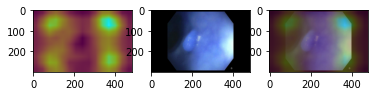

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

cv2.imwrite('output4.png', output)

In [ ]:
!ls

drive  image_66_0329.jpg  output.png  resnet_model_480x270.h5  sample_data


In [ ]:
# pretrained_model.save('resnet_model_480x270.h5')

from google.colab import files

files.download('output3.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for idx in range(len(pretrained_model.layers)):
  print(pretrained_model.get_layer(index = idx).name)

In [ ]:
pretrained_model.summary()